In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

# <b>2 <span style='color:#4285f4'>|</span> Reading the Dataset</b>

In [2]:
train_dir = 'braintumour\Training/'
test_dir = 'braintumour\Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

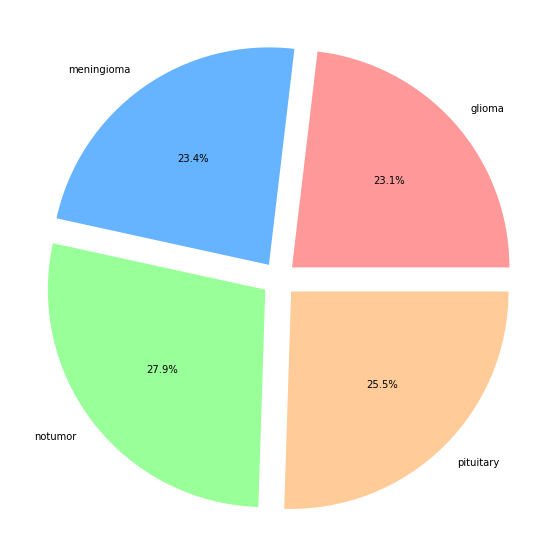

c:\users\legio\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


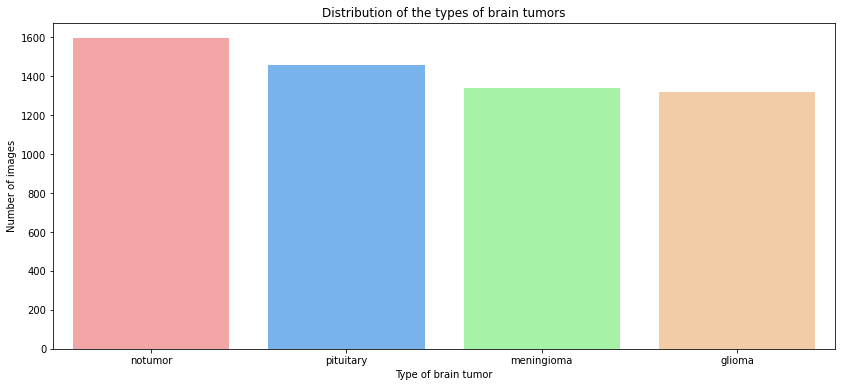

In [3]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()




plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');





#### The dataset is considered balanced

## But what are those labels?

- Not tumor: indicates that those images do not contain a tumor.
- meningioma: is a type of tumor that develops from the membranes that surround the brain and spinal cord.
- glioma: is a type of tumor that develops from glial cells, which are cells that support and protect neurons.
- pituitary tumor: is a type of tumor that develops from the pituitary gland, which is located at the base of the brain.

In [4]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

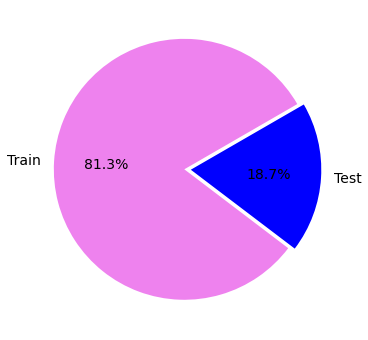

In [5]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);


# <b>3 <span style='color:#4285f4'>|</span> Data Augmentation</b>
- Random Brightness: 80% - 120%  
- Random Contrast: 80% - 120%
- Random sharpness: 80% - 120%

In [6]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

<h3 style="font-family:Sans;"> Example for the data:</h3>

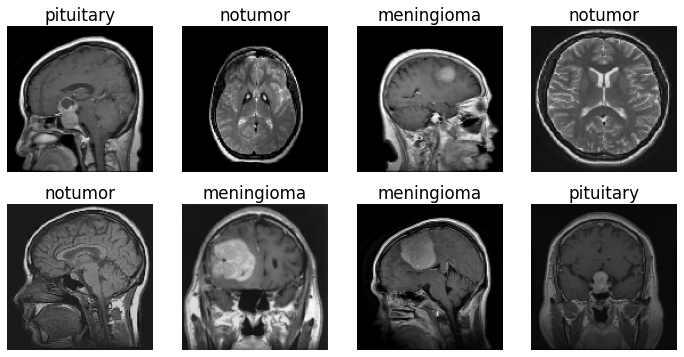

In [7]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()


# <b>4 <span style='color:#4285f4'>|</span> Data Generator</b>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Given a list of paths to images, and the labels, <br>
    this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
</p>

In [8]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# <b>5 <span style='color:#4285f4'>|</span>CNN Model</b>

In [9]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 25088)             0

In [10]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\legio\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [11]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# <b>6 <span style='color:#4285f4'>|</span> Train CNN Model</b>

In [12]:

model.fit(datagen(train_paths, train_labels, batch_size=32, epochs=10), steps_per_epoch=len(train_paths)//32, epochs=10)


Epoch 1/10
178/178 [==============================] - 100s 562ms/step - loss: 0.6902 - accuracy: 0.7207
Epoch 2/10
178/178 [==============================] - 80s 453ms/step - loss: 0.4330 - accuracy: 0.8426
Epoch 3/10
178/178 [==============================] - 80s 448ms/step - loss: 0.3131 - accuracy: 0.8887
Epoch 4/10
178/178 [==============================] - 79s 445ms/step - loss: 0.2249 - accuracy: 0.9217
Epoch 5/10
178/178 [==============================] - 79s 445ms/step - loss: 0.1522 - accuracy: 0.9454
Epoch 6/10
178/178 [==============================] - 80s 451ms/step - loss: 0.1223 - accuracy: 0.9574
Epoch 7/10
178/178 [==============================] - 79s 445ms/step - loss: 0.0751 - accuracy: 0.9748
Epoch 8/10
178/178 [==============================] - 79s 445ms/step - loss: 0.0771 - accuracy: 0.9746
Epoch 9/10
178/178 [==============================] - 80s 449ms/step - loss: 0.0448 - accuracy: 0.9833
Epoch 10/10
178/178 [==============================] - 82s 459ms/step - 

# <b>7 <span style='color:#4285f4'>|</span> Evaluate the model </b>

In [13]:
train_loss, train_acc = model.evaluate(open_images(train_paths), encode_label(train_labels))
test_loss, test_acc = model.evaluate(open_images(test_paths), encode_label(test_labels))

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

41/41 [==============================] - 4s 109ms/step - loss: 0.1760 - accuracy: 0.9451
Train accuracy: 0.9905462265014648
Test accuracy: 0.9450801014900208


## Classification report


In [14]:
predictions = model.predict(open_images(test_paths))
predictions = np.argmax(predictions, axis=1)
print(classification_report(encode_label(test_labels), predictions, target_names=unique_labels))


              precision    recall  f1-score   support

      glioma       0.92      0.90      0.91       300
  meningioma       0.88      0.90      0.89       306
     notumor       0.97      1.00      0.99       405
   pituitary       1.00      0.97      0.98       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



# <b>6.3 <span style='color:#4285f4'>|</span> Train Inception Model</b>

In [15]:
# build inception model
base_model = InceptionV3(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
base_model.layers[-5].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [16]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 8
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)



Epoch 1/8
285/285 [==============================] - 106s 360ms/step - loss: 0.8771 - sparse_categorical_accuracy: 0.6546
Epoch 2/8
285/285 [==============================] - 99s 349ms/step - loss: 0.5408 - sparse_categorical_accuracy: 0.7964
Epoch 3/8
285/285 [==============================] - 95s 333ms/step - loss: 0.4500 - sparse_categorical_accuracy: 0.8268
Epoch 4/8
285/285 [==============================] - 93s 326ms/step - loss: 0.3980 - sparse_categorical_accuracy: 0.8512
Epoch 5/8
285/285 [==============================] - 94s 329ms/step - loss: 0.3487 - sparse_categorical_accuracy: 0.8739
Epoch 6/8
285/285 [==============================] - 103s 360ms/step - loss: 0.3178 - sparse_categorical_accuracy: 0.8825
Epoch 7/8
285/285 [==============================] - 99s 347ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.8874
Epoch 8/8
285/285 [==============================] - 97s 341ms/step - loss: 0.2669 - sparse_categorical_accuracy: 0.9004


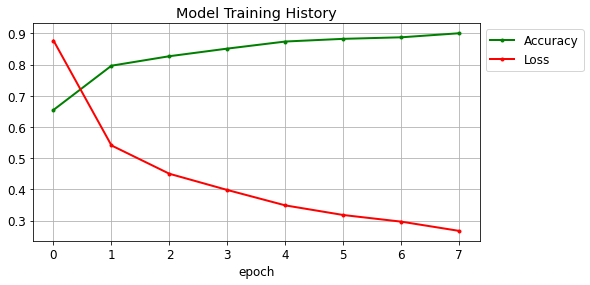

In [18]:

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# <b>7.3 <span style='color:#4285f4'>|</span> Evaluate Model with Test Samples</b>

In [19]:
# Evaluate model with test data
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)



41it [00:30,  1.33it/s]                                                                                                


In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.86      0.84      0.85       300
  meningioma       0.83      0.72      0.77       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.88      0.92      0.90       300

    accuracy                           0.87      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.87      0.87      0.87      1311

